# Q2 TASK 1 EDA 
# Waveforms Plots

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tsfel
from tsfel import get_features_by_domain, time_series_features_extractor
import warnings
warnings.filterwarnings('ignore')


In [10]:
# Load the saved dataset
X_train = np.load("Dataset/X_train.npy")  
y_train = np.load("Dataset/y_train.npy")  

class_map = {1:"WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS",
             4:"SITTING", 5:"STANDING", 6:"LAYING"}

# Find one sample index per class
samples = {}
for class_id in np.unique(y_train):
    idx = np.where(y_train == class_id)[0][0]  
    samples[class_id] = X_train[idx]

# Plot setup
fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharex=True)

time_steps = np.arange(samples[1].shape[0]) / 50  # convert indices to time in seconds (sampling rate 50Hz)

for col, class_id in enumerate(sorted(samples.keys()), start=0):
    sample = samples[class_id]
    title = class_map[class_id]
    
    axs[0, col].plot(time_steps, sample[:, 0], color='r')
    axs[0, col].set_title(title)
    if col == 0:
        axs[0, col].set_ylabel("Acc X")
    
    axs[1, col].plot(time_steps, sample[:, 1], color='g')
    if col == 0:
        axs[1, col].set_ylabel("Acc Y")
    
    axs[2, col].plot(time_steps, sample[:, 2], color='b')
    if col == 0:
        axs[2, col].set_ylabel("Acc Z")
    
    axs[2, col].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

# Major differenecs : Walking, Walking upstairs and Walking downstairs have larger acceleration values are higher compared to standing, sitting and laying, also the fluctuations are more in the case of walking, walking downstairs and upstairs, X axis values are higher for walking, upstairs and downstairs and y, z axis values are lower in comaparison to walking, sitting, the main reason for that is cause of gravity as while sitting, standing only gravity is the only acting force or 9.8 m/s2 acceleration, since x axis is perpendicular to gravity its values are lower compared to y-z axis walking, upstairs, downstairs have more similarity in the graphs compared to sitting, standing, laying Zthere are some sudden fluctuations in the waveform of sitting 
# Small variations are also there because of the body orientation
# difference is there in between walking downstairs and walking upstairs
# Yes, model should be able to classify them 

# Linear Acceleration 

In [11]:
X_train = np.load("Dataset/X_train.npy")
y_train = np.load("Dataset/y_train.npy")

class_map = {1:"WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS",
             4:"SITTING", 5:"STANDING", 6:"LAYING"}

samples = {}
for class_id in np.unique(y_train):
    idx = np.where(y_train == class_id)[0][0]
    samples[class_id] = X_train[idx]

time = np.arange(500) / 50  # 10 seconds at 50Hz

plt.figure(figsize=(18, 4))

for i, class_id in enumerate(sorted(samples.keys()), start=1):
    sample = samples[class_id]
    total_acc = np.sqrt(np.sum(sample**2, axis=1))
    
    if np.isnan(total_acc).any():
        print(f"Warning: NaNs found in class {class_map[class_id]}")
    
    plt.subplot(1, 6, i)
    plt.plot(time, total_acc)
    plt.title(class_map[class_id])
    plt.xlabel("Time (s)")
    plt.grid(True)

plt.tight_layout()
plt.show()


# No, We do not need a machine learning model to differentiate between static activities and dynamic activities, simple threshold value rule can do this since values differ by a lot, however we would need a machine learning model to differentiate within static activities and dynamic activities


# Data visualization using PCA 

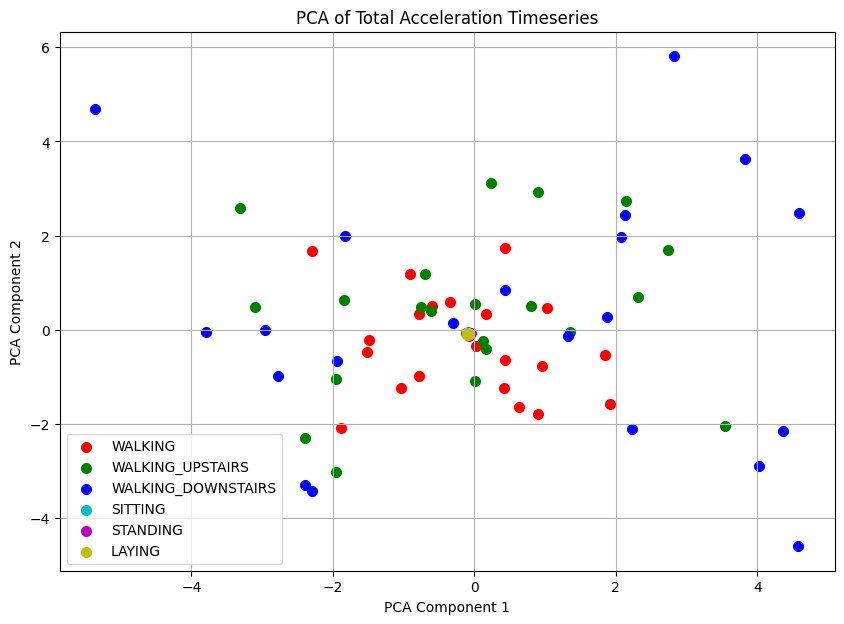

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load data
X_train = np.load("Dataset/X_train.npy")
y_train = np.load("Dataset/y_train.npy")

# Compute total acceleration magnitude
total_acc = np.sqrt(np.sum(X_train**2, axis=2))  # shape (num_samples, 500)

# Apply PCA 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(total_acc)  # shape (num_samples, 2)

class_map = {1:"WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS",
             4:"SITTING", 5:"STANDING", 6:"LAYING"}

colors = ['r', 'g', 'b', 'c', 'm', 'y']

plt.figure(figsize=(10, 7))

for class_id, color in zip(sorted(class_map.keys()), colors):
    idx = y_train == class_id
    sorted_idx = np.argsort(X_pca[idx, 0])
    plt.scatter(X_pca[idx, 0][sorted_idx], X_pca[idx, 1][sorted_idx], 
             color=color, label=class_map[class_id], linewidth=2)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Total Acceleration Timeseries')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
X_train = np.load("Dataset/X_train.npy")  # shape (N, 500, 3)
y_train = np.load("Dataset/y_train.npy")

# Built-in features: mean and std per axis
X_train_feat = np.zeros((X_train.shape[0], 6))  # 3 means + 3 stds
for i in range(X_train.shape[0]):
    X_train_feat[i, 0:3] = X_train[i,:,:3].mean(axis=0)
    X_train_feat[i, 3:6] = X_train[i,:,:3].std(axis=0)

class_map = {1:"WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS",
             4:"SITTING", 5:"STANDING", 6:"LAYING"}
colors = ['r', 'g', 'b', 'c', 'm', 'y']


# PCA on Total Acceleration
total_acc = np.sqrt(np.sum(X_train**2, axis=2))  # shape (N, 500)
pca_total = PCA(n_components=2)
X_pca_total = pca_total.fit_transform(total_acc)

# PCA on TSFEL features
cfg = get_features_by_domain()
def extract_tsfel_features(X):
    feats_list = []
    for act in X:
        df = pd.DataFrame(act[:, :3], columns=['x','y','z'])
        feats = time_series_features_extractor(cfg, df, verbose=0)
        feats_list.append(feats)
    return pd.concat(feats_list, ignore_index=True)

X_train_tsfel_df = extract_tsfel_features(X_train)
scaler = StandardScaler()
X_train_tsfel_scaled = scaler.fit_transform(X_train_tsfel_df.values)
pca_tsfel = PCA(n_components=2)
X_pca_tsfel = pca_tsfel.fit_transform(X_train_tsfel_scaled)

# PCA on built-in mean/std features
scaler = StandardScaler()
X_train_feat_scaled = scaler.fit_transform(X_train_feat)
pca_feat = PCA(n_components=2)
X_pca_feat = pca_feat.fit_transform(X_train_feat_scaled)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(20,6))

def plot_pca(ax, X_pca, y, title):
    for class_id, color in zip(sorted(class_map.keys()), colors):
        idx = y == class_id
        ax.scatter(X_pca[idx,0], X_pca[idx,1], color=color, alpha=0.6, label=class_map[class_id])
    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.grid(True)

plot_pca(axes[0], X_pca_total, y_train, "PCA: Total Acceleration")
plot_pca(axes[1], X_pca_tsfel, y_train, "PCA: TSFEL Features")
plot_pca(axes[2], X_pca_feat, y_train, "PCA: Built-in Mean/Std Features")

axes[0].legend(loc='upper right')
plt.tight_layout()
plt.show()


# Observations: 

# 1. Total Acceleration PCA: partial separation, dynamic vs static overlap exists.
# 2. TSFEL PCA: better separation due to extracted statistical features.
# 3. Built-in Mean/Std PCA: limited separation, as only basic statistics are used.
# 4. TSFEL features are better for visualizing activity classes than simple mean/std.


In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# TSFEL Features Correlation
# Convert TSFEL numpy array back to DataFrame with columns
X_tsfel_df = pd.DataFrame(X_train_tsfel, columns=[f"feat_{i}" for i in range(X_train_tsfel.shape[1])])

# Correlation matrix
corr_tsfel = X_tsfel_df.corr()

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr_tsfel, cmap='coolwarm', center=0)
plt.title("TSFEL Features Correlation Matrix")
plt.show()

# Identify highly correlated features (absolute corr > 0.9)
high_corr_tsfel = np.where(np.abs(corr_tsfel) > 0.9)
high_corr_pairs_tsfel = [(corr_tsfel.index[x], corr_tsfel.columns[y]) 
                         for x, y in zip(*high_corr_tsfel) if x != y and x < y]
print("Highly correlated TSFEL feature pairs (corr > 0.9):")
print(high_corr_pairs_tsfel[:20])  # show first 20 pairs


# UCI-HAR Built-in Features Correlation
X_feat_df = pd.DataFrame(X_train_feat, columns=[f"feat_{i}" for i in range(X_train_feat.shape[1])])
corr_feat = X_feat_df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_feat, cmap='coolwarm', center=0)
plt.title("UCI-HAR Built-in Features Correlation Matrix")
plt.show()

high_corr_feat = np.where(np.abs(corr_feat) > 0.9)
high_corr_pairs_feat = [(corr_feat.index[x], corr_feat.columns[y]) 
                        for x, y in zip(*high_corr_feat) if x != y and x < y]
print("Highly correlated UCI-HAR feature pairs (corr > 0.9):")
print(high_corr_pairs_feat[:20])  # first 20 pairs


Highly correlated TSFEL feature pairs (corr > 0.9):
[('feat_0', 'feat_1'), ('feat_0', 'feat_3'), ('feat_0', 'feat_8'), ('feat_0', 'feat_21'), ('feat_0', 'feat_52'), ('feat_0', 'feat_56'), ('feat_0', 'feat_67'), ('feat_0', 'feat_118'), ('feat_0', 'feat_119'), ('feat_0', 'feat_120'), ('feat_0', 'feat_121'), ('feat_0', 'feat_122'), ('feat_0', 'feat_123'), ('feat_0', 'feat_124'), ('feat_0', 'feat_125'), ('feat_0', 'feat_126'), ('feat_1', 'feat_3'), ('feat_1', 'feat_7'), ('feat_1', 'feat_8'), ('feat_1', 'feat_21')]


Highly correlated UCI-HAR feature pairs (corr > 0.9):
[('feat_3', 'feat_4'), ('feat_3', 'feat_6'), ('feat_3', 'feat_7'), ('feat_3', 'feat_9'), ('feat_3', 'feat_12'), ('feat_3', 'feat_13'), ('feat_3', 'feat_15'), ('feat_3', 'feat_16'), ('feat_3', 'feat_19'), ('feat_3', 'feat_83'), ('feat_3', 'feat_84'), ('feat_3', 'feat_86'), ('feat_3', 'feat_87'), ('feat_3', 'feat_89'), ('feat_3', 'feat_92'), ('feat_3', 'feat_95'), ('feat_3', 'feat_96'), ('feat_3', 'feat_99'), ('feat_3', 'feat_100'), ('feat_3', 'feat_102')]


In [15]:
# Load Raw Accelerometer Data

X_train = np.load("Dataset/X_train.npy")  # shape: (N_train, 500, 3)
y_train = np.load("Dataset/y_train.npy")
X_test = np.load("Dataset/X_test.npy")
y_test = np.load("Dataset/y_test.npy")

# Flatten raw data for Decision Tree
X_train_raw = X_train.reshape(X_train.shape[0], -1)
X_test_raw = X_test.reshape(X_test.shape[0], -1)
print("Raw data shape:", X_train_raw.shape)

# TSFEL Feature Extraction Functions

def extract_tsfel_features(X):
    cfg = get_features_by_domain()
    feature_list = []
    for act in X:
        df = pd.DataFrame(act[:, :3], columns=['x', 'y', 'z'])
        tsfel_feats = time_series_features_extractor(cfg, df, verbose=0)
        feature_list.append(tsfel_feats)
    return pd.concat(feature_list, ignore_index=True)

# Extract TSFEL features as DataFrames
print("Extracting TSFEL features (train)...")
X_train_tsfel_df = extract_tsfel_features(X_train)
print("Extracting TSFEL features (test)...")
X_test_tsfel_df = extract_tsfel_features(X_test)

common_cols = X_train_tsfel_df.columns.intersection(X_test_tsfel_df.columns)
X_train_tsfel_df = X_train_tsfel_df[common_cols]
X_test_tsfel_df = X_test_tsfel_df[common_cols]

# Convert to numpy and scale
scaler = StandardScaler()
X_train_tsfel = scaler.fit_transform(X_train_tsfel_df.values)
X_test_tsfel = scaler.transform(X_test_tsfel_df.values)
print("TSFEL feature shape after alignment:", X_train_tsfel.shape)

# UCI-HAR Built-in Features
X_train_feat = pd.read_csv("UCI HAR Dataset/train/X_train.txt", delim_whitespace=True, header=None)
y_train_feat = pd.read_csv("UCI HAR Dataset/train/y_train.txt", header=None).values.ravel()
X_test_feat = pd.read_csv("UCI HAR Dataset/test/X_test.txt", delim_whitespace=True, header=None)
y_test_feat = pd.read_csv("UCI HAR Dataset/test/y_test.txt", header=None).values.ravel()

scaler = StandardScaler()
X_train_feat = scaler.fit_transform(X_train_feat)
X_test_feat = scaler.transform(X_test_feat)
print("Built-in features shape:", X_train_feat.shape)


# Decision Tree Evaluation
def evaluate_tree(X_train, y_train, X_test, y_test, label="Model"):
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted")
    rec = recall_score(y_test, y_pred, average="weighted")
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\n=== {label} ===")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("Confusion Matrix:\n", cm)
    return acc

# Evaluate all three
acc_raw = evaluate_tree(X_train_raw, y_train, X_test_raw, y_test, "Raw Accelerometer")
acc_tsfel = evaluate_tree(X_train_tsfel, y_train, X_test_tsfel, y_test, "TSFEL Features")
acc_feat = evaluate_tree(X_train_feat, y_train_feat, X_test_feat, y_test_feat, "UCI-HAR Built-in Features")


# Decision Tree Depth Variation
depths = range(2, 9)
acc_raw_list, acc_tsfel_list, acc_feat_list = [], [], []

for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    
    clf.fit(X_train_raw, y_train)
    acc_raw_list.append(accuracy_score(y_test, clf.predict(X_test_raw)))

    clf.fit(X_train_tsfel, y_train)
    acc_tsfel_list.append(accuracy_score(y_test, clf.predict(X_test_tsfel)))

    clf.fit(X_train_feat, y_train_feat)
    acc_feat_list.append(accuracy_score(y_test_feat, clf.predict(X_test_feat)))

plt.figure(figsize=(8,6))
plt.plot(depths, acc_raw_list, '-o', label="Raw Data")
plt.plot(depths, acc_tsfel_list, '-o', label="TSFEL Features")
plt.plot(depths, acc_feat_list, '-o', label="Built-in Features")
plt.xlabel("Decision Tree Depth")
plt.ylabel("Test Accuracy")
plt.title("Decision Tree Accuracy vs Depth")
plt.legend()
plt.grid(True)
plt.show()

#Observations:
print("\nObservations:")
print("1. Raw accelerometer data often overfits due to high dimensionality.")
print("2. TSFEL features improve generalization and reduce dimensionality.")
print("3. Built-in features (561) usually give the best performance.")
print("4. Model may perform poorly on activities like 'Walking Upstairs' vs 'Walking Downstairs' due to overlapping signals.")


Raw data shape: (126, 1500)
Extracting TSFEL features (train)...
Extracting TSFEL features (test)...
TSFEL feature shape after alignment: (126, 468)
Built-in features shape: (7352, 561)

=== Raw Accelerometer ===
Accuracy: 0.6111111111111112
Precision: 0.561111111111111
Recall: 0.6111111111111112
Confusion Matrix:
 [[2 2 2 3 0 0]
 [2 5 1 0 1 0]
 [4 2 1 1 0 1]
 [0 0 0 8 1 0]
 [0 1 0 0 8 0]
 [0 0 0 0 0 9]]

=== TSFEL Features ===
Accuracy: 0.8888888888888888
Precision: 0.8962121212121212
Recall: 0.8888888888888888
Confusion Matrix:
 [[7 1 1 0 0 0]
 [1 8 0 0 0 0]
 [0 2 7 0 0 0]
 [0 0 0 8 1 0]
 [0 0 0 0 9 0]
 [0 0 0 0 0 9]]

=== UCI-HAR Built-in Features ===
Accuracy: 0.8622327790973872
Precision: 0.8632726592620287
Recall: 0.8622327790973872
Confusion Matrix:
 [[456  24  16   0   0   0]
 [ 74 369  28   0   0   0]
 [ 19  53 348   0   0   0]
 [  0   0   0 374 117   0]
 [  0   0   0  75 457   0]
 [  0   0   0   0   0 537]]



Observations:
1. Raw accelerometer data often overfits due to high dimensionality.
2. TSFEL features improve generalization and reduce dimensionality.
3. Built-in features (561) usually give the best performance.
4. Model may perform poorly on activities like 'Walking Upstairs' vs 'Walking Downstairs' due to overlapping signals.
